# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


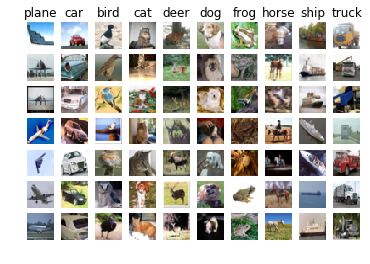

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


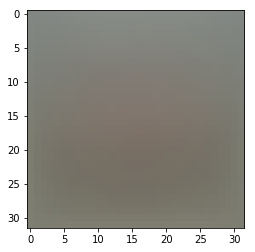

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.280241


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 8.199628 analytic: 8.199628, relative error: 4.383663e-11
numerical: 31.125458 analytic: 31.173655, relative error: 7.736411e-04
numerical: 6.410700 analytic: 6.410700, relative error: 3.775503e-11
numerical: 3.629961 analytic: 3.629961, relative error: 2.066793e-11
numerical: 8.028825 analytic: 8.028825, relative error: 3.864241e-11
numerical: 31.040343 analytic: 30.998508, relative error: 6.743344e-04
numerical: 12.885231 analytic: 12.885231, relative error: 3.346756e-12
numerical: -2.968616 analytic: -2.968616, relative error: 7.365002e-11
numerical: 28.919232 analytic: 28.978071, relative error: 1.016261e-03
numerical: -9.238284 analytic: -9.238284, relative error: 1.951740e-11
numerical: -25.899670 analytic: -25.899670, relative error: 4.212900e-12
numerical: 9.615699 analytic: 9.615699, relative error: 1.747825e-11
numerical: -0.652211 analytic: -0.652211, relative error: 1.875088e-10
numerical: -9.820462 analytic: -9.820462, relative error: 3.881139e-11
numerical: 2.3

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.280241e+00 computed in 0.059146s
Vectorized loss: 9.280241e+00 computed in 0.007140s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.036712s
Vectorized loss and gradient: computed in 0.006978s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 792.240715
iteration 100 / 1500: loss 289.753030
iteration 200 / 1500: loss 108.183000
iteration 300 / 1500: loss 43.074318
iteration 400 / 1500: loss 19.160793
iteration 500 / 1500: loss 9.868954
iteration 600 / 1500: loss 7.338798
iteration 700 / 1500: loss 5.849491
iteration 800 / 1500: loss 5.735110
iteration 900 / 1500: loss 5.584007
iteration 1000 / 1500: loss 5.721113
iteration 1100 / 1500: loss 5.598126
iteration 1200 / 1500: loss 5.575648
iteration 1300 / 1500: loss 5.066941
iteration 1400 / 1500: loss 5.387619
That took 4.239466s


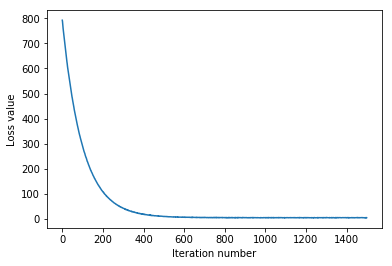

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.362898
validation accuracy: 0.378000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
max_count = 100
max_inter = 1500
for count in range(max_count):
    lr = 10 ** np.random.uniform(-6.75, -6.5)
    reg = 10 ** np.random.uniform(3.6, 3.8)
    svm = LinearSVM()
    svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=True)
    y_train_pred = svm.predict(X_train)
    train_acc = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val)
    val_acc = np.mean(y_val == y_val_pred)
    if val_acc > best_val:
        best_val = val_acc
        best_svm = svm
    results[(lr, reg)] = (train_acc, val_acc)
        
    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 156.453244
iteration 100 / 1500: loss 93.886166
iteration 200 / 1500: loss 61.950484
iteration 300 / 1500: loss 41.569214
iteration 400 / 1500: loss 27.689817
iteration 500 / 1500: loss 20.010267
iteration 600 / 1500: loss 14.336463
iteration 700 / 1500: loss 11.207951
iteration 800 / 1500: loss 8.179498
iteration 900 / 1500: loss 7.520263
iteration 1000 / 1500: loss 6.679130
iteration 1100 / 1500: loss 5.973150
iteration 1200 / 1500: loss 5.674599
iteration 1300 / 1500: loss 5.643785
iteration 1400 / 1500: loss 5.027908
iteration 0 / 1500: loss 166.261413
iteration 100 / 1500: loss 94.225581
iteration 200 / 1500: loss 60.511676
iteration 300 / 1500: loss 39.415044
iteration 400 / 1500: loss 26.698506
iteration 500 / 1500: loss 18.320212
iteration 600 / 1500: loss 13.411856
iteration 700 / 1500: loss 9.544669
iteration 800 / 1500: loss 7.956423
iteration 900 / 1500: loss 6.482266
iteration 1000 / 1500: loss 5.875193
iteration 1100 / 1500: loss 5.943084
iteratio

iteration 1300 / 1500: loss 5.612377
iteration 1400 / 1500: loss 5.287777
iteration 0 / 1500: loss 157.748137
iteration 100 / 1500: loss 104.373252
iteration 200 / 1500: loss 74.923997
iteration 300 / 1500: loss 53.318058
iteration 400 / 1500: loss 39.504190
iteration 500 / 1500: loss 29.104608
iteration 600 / 1500: loss 21.514625
iteration 700 / 1500: loss 16.628497
iteration 800 / 1500: loss 12.781751
iteration 900 / 1500: loss 10.080316
iteration 1000 / 1500: loss 9.105574
iteration 1100 / 1500: loss 7.908500
iteration 1200 / 1500: loss 6.547928
iteration 1300 / 1500: loss 6.521343
iteration 1400 / 1500: loss 5.863157
iteration 0 / 1500: loss 153.579163
iteration 100 / 1500: loss 103.473500
iteration 200 / 1500: loss 75.793368
iteration 300 / 1500: loss 54.873589
iteration 400 / 1500: loss 40.108498
iteration 500 / 1500: loss 29.701320
iteration 600 / 1500: loss 22.508411
iteration 700 / 1500: loss 17.593370
iteration 800 / 1500: loss 13.607236
iteration 900 / 1500: loss 10.955972
i

iteration 1100 / 1500: loss 5.929229
iteration 1200 / 1500: loss 6.054291
iteration 1300 / 1500: loss 5.170494
iteration 1400 / 1500: loss 5.571112
iteration 0 / 1500: loss 171.731868
iteration 100 / 1500: loss 104.419718
iteration 200 / 1500: loss 69.679452
iteration 300 / 1500: loss 47.146358
iteration 400 / 1500: loss 31.808896
iteration 500 / 1500: loss 22.180491
iteration 600 / 1500: loss 16.050364
iteration 700 / 1500: loss 11.944075
iteration 800 / 1500: loss 9.672654
iteration 900 / 1500: loss 8.246548
iteration 1000 / 1500: loss 7.254656
iteration 1100 / 1500: loss 5.973594
iteration 1200 / 1500: loss 6.029558
iteration 1300 / 1500: loss 4.808524
iteration 1400 / 1500: loss 5.134794
iteration 0 / 1500: loss 198.392510
iteration 100 / 1500: loss 103.496001
iteration 200 / 1500: loss 58.714532
iteration 300 / 1500: loss 34.529296
iteration 400 / 1500: loss 21.304610
iteration 500 / 1500: loss 14.053334
iteration 600 / 1500: loss 9.474171
iteration 700 / 1500: loss 7.882816
itera

iteration 900 / 1500: loss 6.106791
iteration 1000 / 1500: loss 5.100970
iteration 1100 / 1500: loss 5.147045
iteration 1200 / 1500: loss 4.883719
iteration 1300 / 1500: loss 4.920479
iteration 1400 / 1500: loss 5.020646
iteration 0 / 1500: loss 176.819159
iteration 100 / 1500: loss 113.553762
iteration 200 / 1500: loss 79.973685
iteration 300 / 1500: loss 55.022081
iteration 400 / 1500: loss 40.011692
iteration 500 / 1500: loss 28.437051
iteration 600 / 1500: loss 20.757501
iteration 700 / 1500: loss 15.913272
iteration 800 / 1500: loss 12.430404
iteration 900 / 1500: loss 10.213897
iteration 1000 / 1500: loss 8.454350
iteration 1100 / 1500: loss 7.842675
iteration 1200 / 1500: loss 6.417067
iteration 1300 / 1500: loss 5.113027
iteration 1400 / 1500: loss 5.585372
iteration 0 / 1500: loss 174.695502
iteration 100 / 1500: loss 93.074255
iteration 200 / 1500: loss 53.657564
iteration 300 / 1500: loss 32.231631
iteration 400 / 1500: loss 19.551795
iteration 500 / 1500: loss 13.914242
ite

iteration 700 / 1500: loss 11.699053
iteration 800 / 1500: loss 9.192195
iteration 900 / 1500: loss 7.406317
iteration 1000 / 1500: loss 6.485507
iteration 1100 / 1500: loss 5.539458
iteration 1200 / 1500: loss 5.906477
iteration 1300 / 1500: loss 5.720894
iteration 1400 / 1500: loss 4.977287
iteration 0 / 1500: loss 176.793056
iteration 100 / 1500: loss 105.321289
iteration 200 / 1500: loss 66.004278
iteration 300 / 1500: loss 42.608212
iteration 400 / 1500: loss 28.958541
iteration 500 / 1500: loss 19.070968
iteration 600 / 1500: loss 13.419312
iteration 700 / 1500: loss 9.835981
iteration 800 / 1500: loss 8.163913
iteration 900 / 1500: loss 7.046139
iteration 1000 / 1500: loss 5.659013
iteration 1100 / 1500: loss 5.880190
iteration 1200 / 1500: loss 5.424410
iteration 1300 / 1500: loss 5.700590
iteration 1400 / 1500: loss 4.739687
iteration 0 / 1500: loss 167.377885
iteration 100 / 1500: loss 95.943331
iteration 200 / 1500: loss 60.717130
iteration 300 / 1500: loss 38.570568
iterati

iteration 500 / 1500: loss 11.440994
iteration 600 / 1500: loss 8.956690
iteration 700 / 1500: loss 7.043456
iteration 800 / 1500: loss 6.027023
iteration 900 / 1500: loss 5.196831
iteration 1000 / 1500: loss 4.817927
iteration 1100 / 1500: loss 5.264470
iteration 1200 / 1500: loss 4.888897
iteration 1300 / 1500: loss 5.039676
iteration 1400 / 1500: loss 5.050245
iteration 0 / 1500: loss 153.962890
iteration 100 / 1500: loss 101.425047
iteration 200 / 1500: loss 73.192123
iteration 300 / 1500: loss 52.363855
iteration 400 / 1500: loss 38.810235
iteration 500 / 1500: loss 28.546863
iteration 600 / 1500: loss 22.264113
iteration 700 / 1500: loss 17.570239
iteration 800 / 1500: loss 13.631747
iteration 900 / 1500: loss 10.998424
iteration 1000 / 1500: loss 9.789611
iteration 1100 / 1500: loss 8.428774
iteration 1200 / 1500: loss 6.910764
iteration 1300 / 1500: loss 5.912250
iteration 1400 / 1500: loss 5.557529
iteration 0 / 1500: loss 171.373500
iteration 100 / 1500: loss 100.566604
itera

iteration 300 / 1500: loss 53.117732
iteration 400 / 1500: loss 35.212109
iteration 500 / 1500: loss 24.526168
iteration 600 / 1500: loss 17.055802
iteration 700 / 1500: loss 12.326411
iteration 800 / 1500: loss 10.215044
iteration 900 / 1500: loss 7.976679
iteration 1000 / 1500: loss 6.761474
iteration 1100 / 1500: loss 6.121966
iteration 1200 / 1500: loss 5.746806
iteration 1300 / 1500: loss 5.455373
iteration 1400 / 1500: loss 4.982054
iteration 0 / 1500: loss 195.939422
iteration 100 / 1500: loss 106.019696
iteration 200 / 1500: loss 63.892915
iteration 300 / 1500: loss 39.562683
iteration 400 / 1500: loss 25.204267
iteration 500 / 1500: loss 16.430478
iteration 600 / 1500: loss 11.910130
iteration 700 / 1500: loss 9.167595
iteration 800 / 1500: loss 7.381144
iteration 900 / 1500: loss 6.773097
iteration 1000 / 1500: loss 5.624340
iteration 1100 / 1500: loss 5.737963
iteration 1200 / 1500: loss 4.786119
iteration 1300 / 1500: loss 4.818742
iteration 1400 / 1500: loss 4.527208
itera

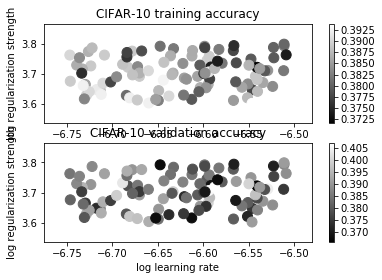

In [20]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [21]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.375000


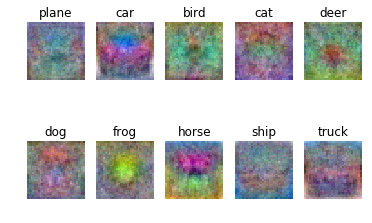

In [22]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*